# Project: Sentiment Analysis for Arabic Reviews
**Author:** Nada Mohammed Alharbi

## Introduction
This project aims to develop a sentiment analysis model for Arabic reviews. Sentiment analysis for Arabic text presents unique challenges due to the complexity of the Arabic language, including variations in dialects, morphology, and syntax. Accurate sentiment analysis has numerous applications, including enhancing customer experience, monitoring public opinion, and improving decision-making processes.

# 1.Modules Required 

In [188]:
!pip install Arabic-Stopwords
!pip install Tashaphyne
!pip install qalsadi
!pip install spacy
!pip install transformers
!pip install --upgrade scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/d0/0b/26ad95cf0b747be967b15fb71a06f5ac67aba0fd2f9cd174de6edefc4674/scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 70.0 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [189]:
# Import necessary libraries
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
from tashaphyne.stemming import ArabicLightStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report , roc_curve, f1_score, accuracy_score, recall_score , roc_auc_score,make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,mean_squared_error,precision_score,recall_score,f1_score
from xgboost import XGBClassifier 
import re
import emoji
from nltk.corpus import stopwords
init_notebook_mode(connected=True)
from sklearn.feature_extraction.text import TfidfVectorizer
import qalsadi.lemmatizer

import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

import networkx as nx
import scipy

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# 2.Exploratory Data Analysis

In [115]:
# Read the dataset
dataFrame = pd.read_csv('../input/CompanyReviews.csv')
dataFrame.drop(columns=["Unnamed: 0"]) # Drop unnecessary columns

,review_description,rating,company
0,رائع,1,talbat
1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشكل اسرع,1,talbat
2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال بالشبكة..مع انه النت عندي تمام شو الحل??,-1,talbat
3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكون فاتحه بقاله كده اكتر من شهر,-1,talbat
...,...,...,...
40041,تجربه جيده بس ينقصها عدم اهتمام خدمة العملاء بالعميل ...كل مره بتواصل مع الشركه وللاسف لم احد رد او اتصال منهم\n,0,swvl
40042,انا ساكنة بمنطقة الكينج ولا توجد عربيات قبل الساعة ٧ ونصف،😏😏😏\n,-1,swvl
40043,جيد ولكن لماذا لا توجد خطوط كثيره من المريوطيه فيصل حتي نادي الرمايه؟ ارجو الرد\n,0,swvl
40044,جيدا جدا ...ولكن الاسعار عاليه جدا\n,0,swvl


# 3.Clean Data

In [116]:
# Check for duplicated reviews
dataFrame.review_description.duplicated().sum()

1042

In [117]:
# Remove duplicated reviews
dataFrame.drop(dataFrame[dataFrame.review_description.duplicated() == True].index, axis = 0, inplace = True)

**Let's take a look on the ratings distribution in the data**

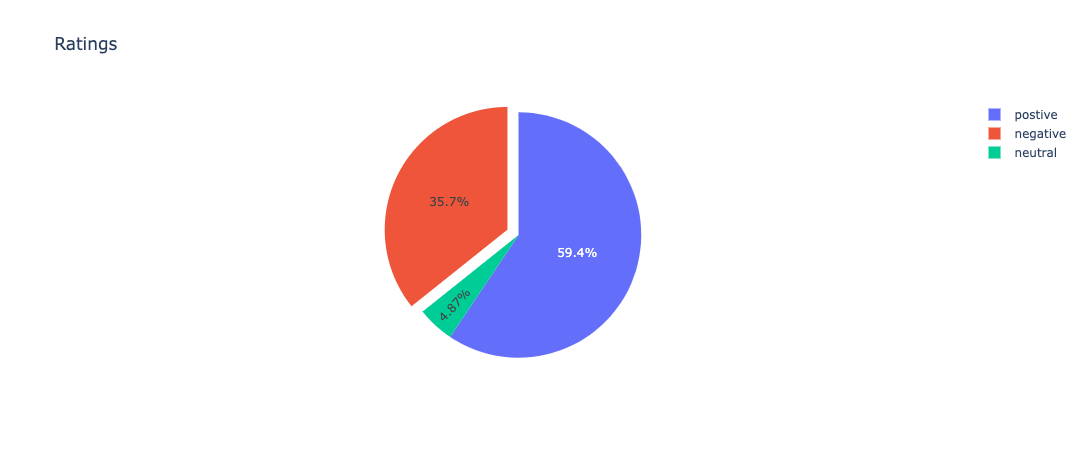

In [118]:
# Visualizing the rating distribution in the data
fig = go.Figure(data=[go.Pie(labels=["postive","negative","neutral"],values=[dataFrame.rating[dataFrame.rating==x].count() for x in dataFrame.rating.unique()],pull=[0, 0.1, 0])])
fig.update_layout(title='Ratings')
iplot(fig)

In [119]:
dataFrame.drop(columns=["Unnamed: 0"],inplace=True)
dataFrame.head()

,review_description,rating,company
0,رائع,1,talbat
1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشكل اسرع,1,talbat
2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال بالشبكة..مع انه النت عندي تمام شو الحل??,-1,talbat
3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكون فاتحه بقاله كده اكتر من شهر,-1,talbat


In [120]:
# Text preprocessing
dataFrame.review_description=dataFrame.review_description.astype(str)

# Remove punctuation and special characters
dataFrame.review_description=dataFrame.review_description.apply(lambda x:re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', x))
dataFrame.review_description=dataFrame.review_description.apply(lambda x:x.replace('؛',"", ))

In [121]:
dataFrame.head()

,review_description,rating,company
0,رائع,1,talbat
1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشكل اسرع,1,talbat
2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال بالشبكة مع انه النت عندي تمام شو الحل,-1,talbat
3,لماذا لا يمكننا طلب من ماكدونالدز,-1,talbat
4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكون فاتحه بقاله كده اكتر من شهر,-1,talbat


In [122]:
# Remove stopwords
stopWords=list(set(stopwords.words("arabic")))#To remove duplictes and return to list again 

# Some words needed to work with to will remove 
for word in ['لا','لكن','ولكن']:
    stopWords.remove(word)

In [123]:
dataFrame.review_description[5]

'أصبح غالي جداً'

In [124]:
" ".join([word for word in dataFrame.review_description[5].split() if word not in stopWords])

'غالي جداً'

In [125]:
# Apply stopword removal to the dataset
dataFrame.review_description=dataFrame.review_description.apply(lambda x:" ".join([word for word in x.split() if word not in stopWords]))

In [126]:
dataFrame.head()

,review_description,rating,company
0,رائع,1,talbat
1,برنامج رائع جدا يساعد تلبيه الاحتياجات بشكل اسرع,1,talbat
2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال بالشبكة انه النت عندي تمام شو الحل,-1,talbat
3,لماذا لا يمكننا طلب ماكدونالدز,-1,talbat
4,البرنامج بيظهر المطاعم مغلقه انها بتكون فاتحه بقاله كده اكتر شهر,-1,talbat


In [127]:
dataFrame.review_description.duplicated().sum()

699

In [128]:
dataFrame.drop(dataFrame[dataFrame.review_description.duplicated() == True].index, axis = 0, inplace = True)
dataFrame.head(10)

,review_description,rating,company
0,رائع,1,talbat
1,برنامج رائع جدا يساعد تلبيه الاحتياجات بشكل اسرع,1,talbat
2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال بالشبكة انه النت عندي تمام شو الحل,-1,talbat
3,لماذا لا يمكننا طلب ماكدونالدز,-1,talbat
4,البرنامج بيظهر المطاعم مغلقه انها بتكون فاتحه بقاله كده اكتر شهر,-1,talbat
5,غالي جداً,-1,talbat
6,جميل جدا رائع,1,talbat
7,للأسف الواحد ينصدم زيادة الاسعار للاسف المطاعم اصبحت معاملتهم رديئة,-1,talbat
8,برنامج توترز توصيل احلى برنامجكم فاشل,-1,talbat
9,كتير تحسن خدمة العملاء لطفين الاخطاء التقنية لكن بتصلحوها بسرعة وبعض التاخير سياسيتكم وتسويقكم افضل كريم بالنسبة الي متفقين,1,talbat


In [129]:
dataFrame.review_description[17]

'نزلته ومفيش الخصم اللي قلته علي 3طلبات اعمل ايه عشان يطبق'

In [130]:
# Removing numeric characters
dataFrame.review_description=dataFrame.review_description.apply(lambda x:''.join([word for word in x if not word.isdigit()]))

In [131]:
# The output of removing the numeric characters in 17th review description 
dataFrame.review_description[17]

'نزلته ومفيش الخصم اللي قلته علي طلبات اعمل ايه عشان يطبق'

# 4.Apply lemmatization

In [132]:
# Lemmatization
lemmer = qalsadi.lemmatizer.Lemmatizer()
dataFrame.review_description=dataFrame.review_description.apply(lambda x:lemmer.lemmatize_text(x))
dataFrame.review_description=dataFrame.review_description.apply(lambda x:" ".join(x))
dataFrame.head(10)

,review_description,rating,company
0,رائع,1,talbat
1,برنامج رائع جدا ساعد ألب احتياج شكل سرع,1,talbat
2,تطبيق لا يغتح دائم بيعطيني لا أوجد اتصال شبكة نهو نت عند تمام شوى حل,-1,talbat
3,لماذا لا أمكن طلب ماكدونالدز,-1,talbat
4,برنامج بيظهر مطاعم مغلق انها تكون فاتح بقال دهي اكترى شهر,-1,talbat
5,غالى جد,-1,talbat
6,جميل جدا رائع,1,talbat
7,أسف واحد ينصدم زيادة الاسعار للاسف مطاعم اصبحت معامل رديئة,-1,talbat
8,برنامج توترز توصيل احلى برنامج فاشل,-1,talbat
9,كتير تحسن خدم عملاء لطف الاخطاء تقني لكن بتصلحوها سرع بعض التاخير سياسة تسويق فضل ريم نسب ال متفق,1,talbat


In [133]:
dataFrame.review_description.head(20)

0                                                                                                  رائع
1                                                               برنامج رائع جدا ساعد ألب احتياج شكل سرع
2                                  تطبيق لا يغتح دائم بيعطيني لا أوجد اتصال شبكة نهو نت عند تمام شوى حل
3                                                                          لماذا لا أمكن طلب ماكدونالدز
4                                             برنامج بيظهر مطاعم مغلق انها تكون فاتح بقال دهي اكترى شهر
5                                                                                               غالى جد
6                                                                                         جميل جدا رائع
7                                            أسف واحد ينصدم زيادة الاسعار للاسف مطاعم اصبحت معامل رديئة
8                                                                   برنامج توترز توصيل احلى برنامج فاشل
9     كتير تحسن خدم عملاء لطف الاخطاء تقني لكن بتصلحوها سرع بعض 

In [134]:
dataFrame.review_description.duplicated().sum()

1203

In [135]:
# Remove any duplicated reviews after preprocessing
dataFrame.drop(dataFrame[dataFrame.review_description.duplicated() == True].index, axis = 0, inplace = True)

In [136]:
# Feature extraction using TF-IDF
vectorizer=TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
FeatureText=vectorizer.fit_transform(dataFrame.review_description)
X=pd.DataFrame(FeatureText.toarray(),columns=vectorizer.get_feature_names_out())

In [137]:
# Preparing the target variable
Y=dataFrame.rating

In [138]:
# Splitting the dataset into training and testing sets
x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42,test_size=0.20,shuffle=True)

# 5.Apply Knowledge Graph as Knowledge-based approach

In [139]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
    print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [140]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    for tok in nlp(sent):
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text

            # chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

            # chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.strip(), ent2.strip()]

In [141]:
get_entities("برنامج بيظهر مطاعم مغلق انها تكون فاتح بقال دهي اكترى شهر")

['مطاعم مغلق انها انها', 'بقال اكترى شهر شهر']

In [142]:
from tqdm import tqdm
entity_pairs = []

for i in tqdm(dataFrame["review_description"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 37102/37102 [04:19<00:00, 142.97it/s]


In [143]:
entity_pairs[10:20]

[['', ''],
 ['محل كثير كثير', 'توصيل فاضة تطبيق تطبيق'],
 ['', ''],
 ['', 'أحد أربعاء أربعاء'],
 ['بحث مطعم مطلوب قام', 'مطاعم مزاج مزاج'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['جيد', ''],
 ['', '']]

In [144]:
from spacy.matcher import Matcher

def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    # Define the pattern
    pattern = [{'DEP': 'ROOT'},
               {'DEP': 'prep', 'OP': "?"},
               {'DEP': 'agent', 'OP': "?"},
               {'POS': 'ADJ', 'OP': "?"}]

    # Add pattern to the matcher
    matcher.add("matching_1", [pattern])

    matches = matcher(doc)
    k = len(matches) - 1

    # Check if there are any matches
    if k >= 0:
        span = doc[matches[k][1]:matches[k][2]]
        return span.text
    else:
        return "No relation found"


relation = get_relation("برنامج رائع جدا ساعد ألب احتياج شكل سرع")
print(relation)


رائع


In [145]:
relations = [get_relation(i) for i in tqdm(dataFrame["review_description"])]

100%|██████████| 37102/37102 [04:41<00:00, 131.83it/s]


In [146]:
pd.Series(relations).value_counts()[:50]

رائع      1229
تطبيق      856
جدا        718
طلبة       523
جميل       473
جيد        413
توصيل      366
ممتاز      361
الله       318
برنامج     295
شكر        222
بارد       221
صراح       219
😍          194
وانا       193
سريع       192
تجربة      182
حلو        181
مطاعم      177
مفيد       165
سهل        158
منطق       153
كثير       147
مو         144
اتمنى      143
معى        140
كتير       129
وقت        126
👎          122
روع        116
جد         114
❤          114
مريح       113
عالم       106
زبال       105
فضل        105
وصل        105
سائق       103
رجع        102
تحميل      102
نجم         98
كابتن       97
فاشل        95
صور         92
ياريت       92
مبلغ        90
انا         89
مناطق       88
حسب         83
مكان        81
Name: count, dtype: int64

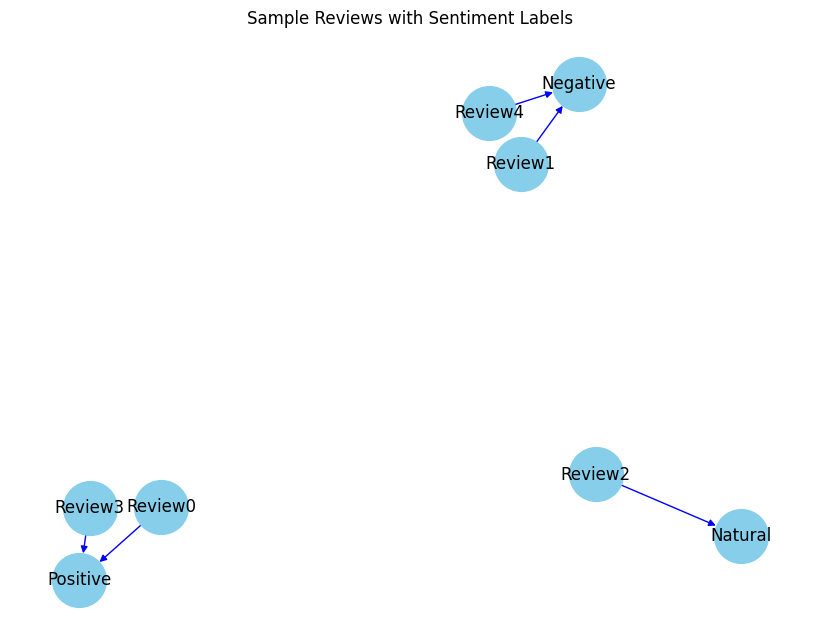

In [187]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt

# Load the Arabic spaCy model 
nlp = spacy.blank('ar')

# Create a sample from the DataFrame
import pandas as pd
data = {'review_text': [' برنامج رائع جدا ساعد ألب احتياج شكل سرع','تطبيق لا يغتح دائم بيعطيني لا أوجد اتصال شبكة نهو نت عند تمام شوى حل', 'عادي', 'ممتاز', 'غالى جد'],
        'label': ['Positive', 'Negative', 'Natural', 'Positive', 'Negative']}
df = pd.DataFrame(data)

# Initialize a directed graph
G = nx.DiGraph()

# Add nodes and edges from the DataFrame
for index, row in df.iterrows():
    review_node = f"Review{index}"  
    sentiment = row['label']
    G.add_node(review_node)
    G.add_node(sentiment)
    G.add_edge(review_node, sentiment)  

# Plot the graph
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='blue', node_size=1500, font_size=12)
plt.title('Sample Reviews with Sentiment Labels')
plt.show()


In [153]:
# Function to evaluate model performance
def get_accuracy(name, trained_model , x_train, y_train, x_test, y_test):
    # Predictions on test set
    tree_predict = trained_model.predict(x_test)
    # Evaluation metrics
    print("Testing accuracy   :",metrics.accuracy_score(y_test, tree_predict)*100 , "%")
    print("MSE [TEST]          :",mean_squared_error(y_test, tree_predict))

    # Predictions on train set for comparison
    tree_predict1 = trained_model.predict(x_train)
    print("Training accuracy  :",metrics.accuracy_score(y_train, tree_predict1)*100 ,"%")
    print("MSE [TRAIN]         :",mean_squared_error(y_train, tree_predict1))

    # Additional metrics
    print("precision : ",precision_score(y_test, tree_predict,average='micro'))
    print("recall    : ",recall_score(y_test, tree_predict,average='micro'))
    print("f1_score  : ",f1_score(y_test, tree_predict,average='micro'))


    cf1 = confusion_matrix(y_test,tree_predict)
    sns.heatmap(cf1,annot=True,fmt = '.0f')
    plt.xlabel('prediction')
    plt.ylabel('Actual')
    plt.title(name+ ' Confusion Matrix')
    plt.show()

    print(classification_report(y_train,  trained_model.predict(x_train)))
    print(classification_report(y_test,  trained_model.predict(x_test)))

# 6.Apply Random Forrest as machine learning approach

Testing accuracy   : 81.84880743835062 %
MSE [TEST]          : 0.5760679153752863
Training accuracy  : 96.93069640510764 %
MSE [TRAIN]         : 0.1074087800276271
precision :  0.8184880743835062
recall    :  0.8184880743835062
f1_score  :  0.8184880743835061


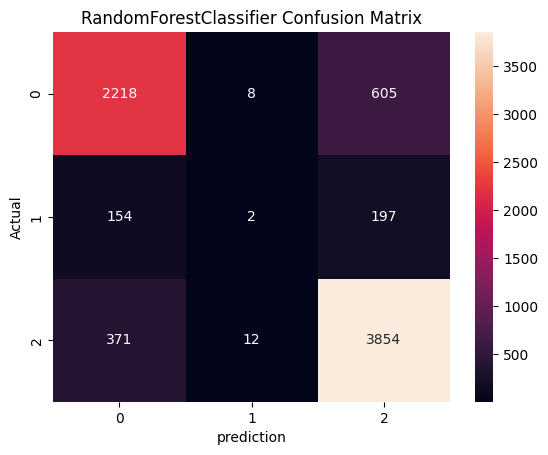

              precision    recall  f1-score   support

          -1       0.99      0.93      0.96     10786
           0       0.99      0.90      0.95      1462
           1       0.95      1.00      0.97     17433

    accuracy                           0.97     29681
   macro avg       0.98      0.94      0.96     29681
weighted avg       0.97      0.97      0.97     29681

              precision    recall  f1-score   support

          -1       0.81      0.78      0.80      2831
           0       0.09      0.01      0.01       353
           1       0.83      0.91      0.87      4237

    accuracy                           0.82      7421
   macro avg       0.58      0.57      0.56      7421
weighted avg       0.79      0.82      0.80      7421



In [190]:
# Random Forrest algorithm
from sklearn.ensemble import RandomForestClassifier
trained_clf_random_forest = RandomForestClassifier().fit(x_train, y_train)
get_accuracy('RandomForestClassifier',trained_clf_random_forest,x_train, y_train, x_test, y_test)

### The difference in performance between the training and testing sets suggests that the model may be overfitting to the training data.

# 7.Apply Naive Base as machine learning approach

Testing accuracy   : 82.77860126667565 %
MSE [TEST]          : 0.545748551408166
Training accuracy  : 83.80782318655032 %
MSE [TRAIN]         : 0.5005222196017655
precision :  0.8277860126667566
recall    :  0.8277860126667566
f1_score  :  0.8277860126667566


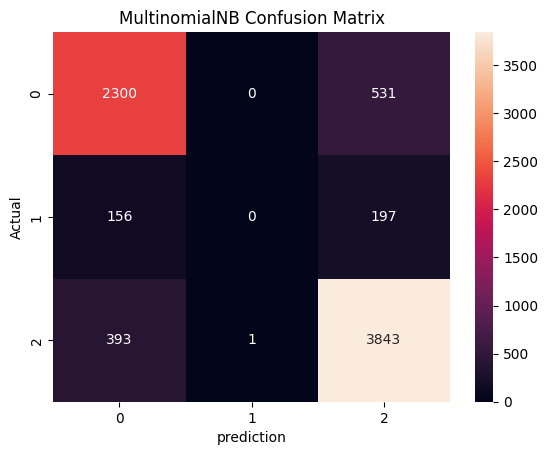

              precision    recall  f1-score   support

          -1       0.81      0.82      0.82     10786
           0       0.88      0.00      0.01      1462
           1       0.85      0.92      0.88     17433

    accuracy                           0.84     29681
   macro avg       0.85      0.58      0.57     29681
weighted avg       0.84      0.84      0.82     29681

              precision    recall  f1-score   support

          -1       0.81      0.81      0.81      2831
           0       0.00      0.00      0.00       353
           1       0.84      0.91      0.87      4237

    accuracy                           0.83      7421
   macro avg       0.55      0.57      0.56      7421
weighted avg       0.79      0.83      0.81      7421



In [191]:
# Naive Base algorithm
from sklearn.naive_bayes import MultinomialNB
trained_clf_multinomial_nb = MultinomialNB().fit(x_train, y_train)
get_accuracy('MultinomialNB',trained_clf_multinomial_nb,x_train, y_train, x_test, y_test)